In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import interactive
import matplotlib.pyplot as plt
import numpy as np
import random as random

from sklearn import decomposition
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler)
from sklearn.manifold import Isomap
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from random import shuffle
from mpl_toolkits.mplot3d import Axes3D


C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setup formatting of output

def myformat(x):
    if isinstance(x, str):
        return [x]
    else:
        return '{:.3f}'.format(x)

# This is a string for visual separation of different sections of output.
seperator = '\n' + ('-'*80) + '\n'

In [3]:
# Get pre-computed ratios data and training data
ratios_df = pd.read_csv('ratiostest.csv')
train_df = pd.read_csv('Data/train.csv')

# Set indices for training and ratios data. Then combine. 
# Result printed to make sure isoperimetric ratios properly line up.
train_df = train_df.set_index('id')

ratios_df = ratios_df.set_index('id')
print(seperator, 'Ratios Data Set Info')
print(ratios_df.info())
print(ratios_df[:6].applymap(myformat))

train_df = pd.concat([train_df, ratios_df], axis = 1, join_axes = [train_df.index])
print(seperator, 'After adding ratios column, training data is\n')
train_df[:4].applymap(myformat).head()


--------------------------------------------------------------------------------
 Ratios Data Set Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 1 to 1584
Data columns (total 1 columns):
isopratio    1584 non-null float64
dtypes: float64(1)
memory usage: 24.8 KB
None
   isopratio
id          
1     10.619
2     12.229
3     10.981
4     10.133
5     11.181
6     11.584

--------------------------------------------------------------------------------
 After adding ratios column, training data is



,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,isopratio
id,,,,,,,,,,,,,,,,,,,,,
1,[Acer_Opalus],0.008,0.023,0.023,0.004,0.012,0.010,0.027,0.000,0.002,...,0.000,0.003,0.003,0.035,0.000,0.000,0.005,0.000,0.025,10.619
2,[Pterocarya_Stenoptera],0.006,0.000,0.031,0.016,0.025,0.002,0.020,0.000,0.000,...,0.000,0.000,0.001,0.023,0.000,0.000,0.001,0.039,0.022,12.229
3,[Quercus_Hartwissiana],0.006,0.010,0.020,0.008,0.004,0.006,0.068,0.000,0.000,...,0.000,0.006,0.001,0.008,0.000,0.000,0.000,0.021,0.003,10.981
5,[Tilia_Tomentosa],0.000,0.004,0.023,0.006,0.021,0.020,0.023,0.000,0.014,...,0.001,0.000,0.000,0.021,0.000,0.000,0.018,0.000,0.048,11.181


In [4]:
# Now we need to encode the species category and do a Stratified Shuffle Split for cross validation.

le = LabelEncoder().fit(train_df.species)
train_df['species'] = le.transform(train_df.species)

# Now seperate data for cross validation

sss = StratifiedShuffleSplit(train_df['species'].values, 10, test_size = 0.3, random_state = 17)
for train_i, test_i in sss:
    train_index = train_i
    test_index = test_i

test_df = train_df.iloc[test_index]
train_df = train_df.iloc[train_index]
y_train = train_df['species'].values
y_test = test_df['species'].values

print(seperator, 'After cross validation separation, description of the training data species count = \n', train_df[['species']].applymap(myformat).describe())
print('After cross validation separation, description of the test data = \n', test_df[['species']].applymap(myformat).describe())


--------------------------------------------------------------------------------
 After cross validation separation, description of the training data species count = 
        species
count      693
unique      99
top     64.000
freq         7
After cross validation separation, description of the test data = 
        species
count      297
unique      99
top     64.000
freq         3



--------------------------------------------------------------------------------
 After grouping by species and reordering, traingroups = 
         isopratio
species          
25          8.776
21          8.820
34          8.836
23          8.962
Order of species is
 [25 21 34 23 31 39 97 62 52 40]

--------------------------------------------------------------------------------
 Training Data indices after attaching ordering
 Int64Index([1310, 1123, 879, 952], dtype='int64', name='id')


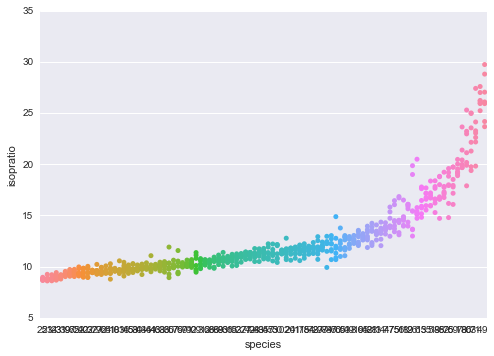

In [5]:
# To get a look at how the isoperimetric ratios vary by species, we order the species 
# by increasing mean isoperimetric ratio. Then we graph ratio vs species.

traingroups = train_df[['species', 'isopratio']].groupby('species').mean()
traingroups = traingroups.sort_values(by = 'isopratio', ascending = 1)
print(seperator, 'After grouping by species and reordering, traingroups = \n', traingroups.applymap(myformat)[:4])
speciesorder = traingroups.index.values
print('Order of species is\n', speciesorder[:10])

train_df['species'] = train_df['species'].astype('category')
train_df['species'] = train_df['species'].cat.set_categories(speciesorder, ordered = True)

print(seperator, 'Training Data indices after attaching ordering\n', train_df.applymap(myformat).index[:4])

# Plot species on x-axis and ratios on y-axis. Categories appear in the order we specified above.
# Therefore, they appear in order of increasing mean ratio.

ax = sns.stripplot(x = 'species', y = 'isopratio', data = train_df)
plt.show()

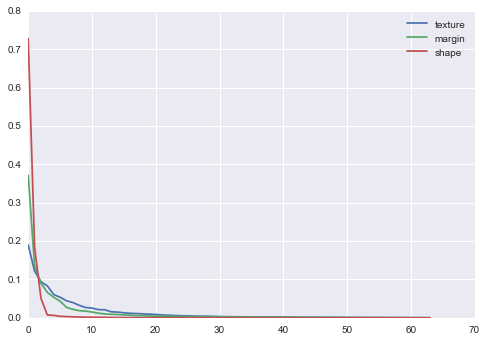

In [6]:
# Now we will do PCA for the texture, shape, and margin features. We won't combine these 
# categories of features as it isn't clear how their length scales should be compared. Before we decide 
# on the number of components to keep, we need to keep analyze the variance ratios which we keep inside
# a dictionary.

variance_ratios = {}

for name in ['texture', 'shape', 'margin']:
    pca = decomposition.PCA()
    collist =[name + str(i + 1) for i in range(64)]
    pca.fit(train_df[collist])
    variance_ratios[name] = pca.explained_variance_ratio_

# Graph variance ratios of PCA for each attribute
for series in variance_ratios.values():
    plt.plot(series)
plt.legend(variance_ratios.keys(), loc = 'upper right')
plt.show()

In [7]:
# Using the graph of the variances, now decide which number of components of PCA to keep. Keep in a dictionary.

ncomponents = {}
ncomponents['texture'] = 4
ncomponents['shape'] = 2
ncomponents['margin'] = 6
ncomponents['isopratio'] = 1

# Now we use SciKit Pipeline and Function Transformer to allow feature selection and
# separate PCA on each feature, using the number of components we have decided to keep.
# For now, we keep track of pipelinekeys for each feater. Later we may put everything 
# into a single transformer using Pipeline and Feature Union.
    
def getColumns(name_, dfvalues):
    start = train_df.columns.get_loc(name_ + str(1))
    end = 1 + train_df.columns.get_loc(name_ + str(64))
    return dfvalues[:, start:end]

# Create dictionary of functions for getting columns of each feature.
# Note the use of double lambdas to properly scope the use of name.

colFunc = {}
for name in ['texture', 'shape', 'margin']:
    colFunc[name] = (lambda n: lambda X : getColumns(n, X))(name)
    
getisoploc = lambda : train_df.columns.get_loc("isopratio")
colFunc['isopratio'] = lambda X : X[:, getisoploc():1+getisoploc()]

pipelinekeys = {}
for name in ['texture', 'shape', 'margin', 'isopratio']:
    key = ('cols_' + name, FunctionTransformer(colFunc[name]))
    pipelinekeys[name] = [key]
           
for name in ['texture', 'shape', 'margin']:
    key = ('pca_' + name, decomposition.PCA(n_components = ncomponents[name]))
    pipelinekeys[name].append(key)


In [8]:
# Test the column getting functions for accuracy.

for name in ['texture', 'shape', 'margin']:
    Xtest = colFunc[name](train_df.values)
    print('For ' + name + ' we get shape = ', Xtest.shape)
    print('Comparison of first columns is')
    Xtest = [Xtest[:,0], train_df[name + '1'].values]
    Xtest = np.array(Xtest).T[:3]
    print(Xtest)
    
Xtest = colFunc['isopratio'](train_df.values)
print('For isopratio we get shape = ', Xtest.shape)
Xtest = [Xtest[:,0], train_df['isopratio'].values]
Xtest = np.array(Xtest).T[:3]
print(Xtest)

For texture we get shape =  (693, 64)
Comparison of first columns is
[[0.12207 0.12207]
 [0.0 0.0]
 [0.00293 0.00293]]
For shape we get shape =  (693, 64)
Comparison of first columns is
[[0.00042118 0.00042118]
 [0.0010278 0.0010278]
 [0.00099926 0.00099926]]
For margin we get shape =  (693, 64)
Comparison of first columns is
[[0.009766 0.009766]
 [0.039062 0.039062]
 [0.027344 0.027344]]
For isopratio we get shape =  (693, 1)
[[12.051152916700001 12.051152916700001]
 [9.583762978280001 9.583762978280001]
 [10.4805416735 10.4805416735]]


In [9]:
# Transform the training data to continue building our model. Double check that the 
# transformed data has the right shape. Also double check contents of newData, especially
# to make sure there isn't any scoping issues in our Function Transformer that cause all
# of the features to be pulled from the same data.

newData = {}

for name in ['texture', 'shape', 'margin', 'isopratio']:
    transformer = Pipeline(pipelinekeys[name])
    newData[name] = transformer.fit_transform(train_df.values)
    height, width = newData[name].shape
    print("For " + name + ", shape = " + str(newData[name].shape))
    print("newData[" + name +"][:4] = ")
    print(newData[name][:4])

For texture, shape = (693, 4)
newData[texture][:4] = 
[[ 0.00781469 -0.1170446  -0.00654753  0.04130947]
 [ 0.16745287  0.09626078 -0.05504701 -0.05830207]
 [ 0.04675485 -0.11217717  0.05241992  0.01912702]
 [ 0.04292097 -0.04847828 -0.01422555 -0.07668434]]
For shape, shape = (693, 2)
newData[shape][:4] = 
[[-0.00174536 -0.00101563]
 [ 0.00063477  0.00099526]
 [-0.00023779  0.00115718]
 [-0.00179387 -0.00022165]]
For margin, shape = (693, 6)
newData[margin][:4] = 
[[-0.02805482  0.01365204 -0.03869438  0.01482869  0.0042074   0.0021027 ]
 [ 0.11349612 -0.06824881 -0.0066569   0.01362626 -0.03301563 -0.04241852]
 [ 0.01308141 -0.00328548 -0.03609774 -0.04946091 -0.00867878 -0.00512571]
 [ 0.02569113  0.01639262  0.00980169 -0.0322103  -0.02996315  0.01660936]]
For isopratio, shape = (693, 1)
newData[isopratio][:4] = 
[[ 12.05115292]
 [  9.58376298]
 [ 10.48054167]
 [ 10.00662712]]


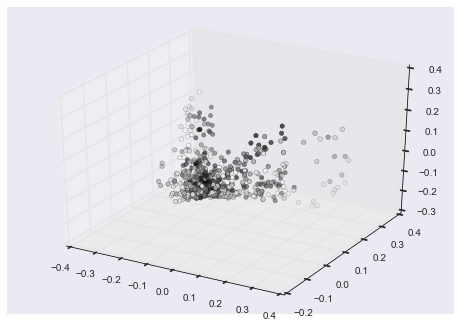

In [10]:
# Make 3d scatterplot
colordict = {}
for i in range(len(speciesorder)):
    colordict[speciesorder[i]] = i

plotcolors = train_df['species'].apply(lambda x: colordict[x]) 
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection = '3d' )
ax2.scatter(newData['texture'][:,0], newData['texture'][:,1], newData['texture'][:,2], c = plotcolors)

plt.show()

In [11]:
# Make an isomap for the texture data.

newNComponents = 3
transformer = Isomap(n_neighbors = 5, n_components = newNComponents)
newData['texture'] = transformer.fit_transform(newData['texture'])
key = ('isomap_texture', transformer)
pipelinekeys['texture'].append(key)

# Adjust the number of components for texture feature.

ncomponents['texture'] = newNComponents

# Make 3d scatterplot for transformed data.

#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111, projection = '3d' )
#ax2.scatter(newData['texture'][:,0], newData['texture'][:,1], newData['texture'][:,2], c = plotcolors)

#plt.show()

In [12]:
# Add scalers to pipelinekeys. Scalers help with normalization for comparison.
# For each feature, we only fit our scaler using only the first component. We don't
# want to independently normalize the other components as they represent smaller
# variations in the feature.

def scaleUsingFirstFeature(X):
    scaler = MinMaxScaler()
    scaler.fit(X[:,0].reshape(-1,1))
    return scaler.transform(X)
    
for name in ['texture', 'shape', 'margin', 'isopratio']:
    transformer = FunctionTransformer(scaleUsingFirstFeature)
    key = ('scaler_' + name, transformer)
    pipelinekeys[name].append(key)
    newData[name] = transformer.transform(newData[name])

In [13]:
# Double Check the Contents of the Pipeline Keys.

pipelinekeys

{'isopratio': [('cols_isopratio', FunctionTransformer(accept_sparse=False,
             func=<function <lambda> at 0x0000027792A8A048>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y=False, validate=True)),
  ('scaler_isopratio', FunctionTransformer(accept_sparse=False,
             func=<function scaleUsingFirstFeature at 0x000002779309A730>,
             inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
             validate=True))],
 'margin': [('cols_margin', FunctionTransformer(accept_sparse=False,
             func=<function <lambda>.<locals>.<lambda> at 0x0000027792A8ABF8>,
             inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
             validate=True)),
  ('pca_margin',
   PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('scaler_margin', FunctionTransformer(accept_sparse=False,
             func=<function scaleUsingFirstFeature at 0x000002

In [14]:
debugkeys = [('a', Pipeline(pipelinekeys['texture'])), ('b', Pipeline(pipelinekeys['isopratio']))]
testtransformer = FeatureUnion(debugkeys)
Xdebug = testtransformer.fit_transform(train_df.values)
Xdebug[:3]

array([[ 0.45583009,  0.36127994,  0.49180444,  0.16296611],
       [ 0.63235437,  0.5673329 ,  0.47737666,  0.04632266],
       [ 0.51355066,  0.32065574,  0.43195216,  0.088717  ]])

In [15]:
# Set up preprocessing with and without Isoperimetric Ratios. Use SciKit Feature Union.

transformerkeys = []
for name in ['texture', 'shape', 'margin']:
    key = (name, Pipeline(pipelinekeys[name]))
    transformerkeys.append(key)

combined = {}
combined['without'] = FeatureUnion(transformerkeys.copy())

isopkey = ('isopratio', Pipeline(pipelinekeys['isopratio']))
transformerkeys.append(isopkey)
combined['with'] = FeatureUnion(transformerkeys.copy())


# Set up training/testing data for the cases of with and without isoperimetric ratios. To be used in estimator.
X_train = {}
X_test = {}
for name in ['with', 'without']:
    X_train[name] = combined[name].fit_transform(train_df.values)
    X_test[name] = combined[name].transform(test_df.values)

transformerkeys

[('texture',
  Pipeline(steps=[('cols_texture', FunctionTransformer(accept_sparse=False,
            func=<function <lambda>.<locals>.<lambda> at 0x0000027792E9F048>,
            inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True)), ('pca_texture', PCA(copy=True, iterated_power='auto', n_c...         inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True))])),
 ('shape',
  Pipeline(steps=[('cols_shape', FunctionTransformer(accept_sparse=False,
            func=<function <lambda>.<locals>.<lambda> at 0x0000027792E9F950>,
            inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True)), ('pca_shape', PCA(copy=True, iterated_power='auto', n_compo...         inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True))])),
 ('margin',
  Pipeline(steps=[('cols_margin', FunctionTransformer(accept_sparse=False,
            func=<function <lambda>.<

In [16]:
ncomponents

{'isopratio': 1, 'margin': 6, 'shape': 2, 'texture': 3}

In [17]:
# Do K Nearest Neighbors for the cases of with and without isoperimetric ratios.

neighborsrange = range(12)
acc = {'with' : [], 'without' : []}
logloss = {'with' : [], 'without' : []}

weightRange = [0.5, 1.0]
parameters = [(x, y, z, w, nn) for x in weightRange 
                               for y in weightRange 
                               for z in weightRange 
                               for w in weightRange 
                               for nn in neighborsrange]
parameters = [parameters[i] + (i,) for i in range(len(parameters))]
def applyWeightsWith( X, weightDict):
    i = 0
    result = np.empty(X.shape)
    for name in ['texture', 'shape', 'margin', 'isopratio']:
        i2 = i + ncomponents[name]
        result[:, i:i2] = weightDict[name] * X[:, i:i2]
        i = i2
    return result
def applyWeightsWithout(X, weightDict):
    i = 0
    result = np.empty(X.shape)
    for name in ['texture', 'shape', 'margin']:
        i2 = i + ncomponents[name]
        result[:, i:i2] = weightDict[name] * X[:, i:i2]
        i = i2
    return result

X_train2 = {}
X_test2 = {}

for textureW, shapeW, marginW, isopratioW, kneighbors, i in parameters:
    knn = KNeighborsClassifier(kneighbors + 1)
    
    weightDict = {'texture' : textureW, 'shape' : shapeW, 'margin' : marginW, 'isopratio' : isopratioW}
    X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
    X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
    X_train2['without'] = applyWeightsWithout( X_train['without'], weightDict)
    X_test2['without'] = applyWeightsWithout( X_test['without'], weightDict)
    
    for name in ['with', 'without']:
    
        # Make the K Nearest Neighbor classifier using right pipeline
        
        #clfkeys = [("combined", combined[name]), ("knn", knn)]
        #clf = Pipeline( clfkeys )
        clf = knn
        clf.fit(X_train2[name], y_train)
        test_predictions = clf.predict(X_test2[name])
        prob_predictions = clf.predict_proba(X_test2[name])
    
        # Accuracy and LogLoss

        acc[name].append(accuracy_score(y_test, test_predictions))
        logloss[name].append(log_loss(y_test, prob_predictions))
   
    if(i % int(len(parameters)/10) == 0):
        print('Finished Processing', textureW, shapeW, marginW, isopratioW, kneighbors)
    
'Finished Processing'

Finished Processing 0.5 0.5 0.5 0.5 0
Finished Processing 0.5 0.5 0.5 1.0 7
Finished Processing 0.5 0.5 1.0 1.0 2
Finished Processing 0.5 1.0 0.5 0.5 9
Finished Processing 0.5 1.0 1.0 0.5 4
Finished Processing 0.5 1.0 1.0 1.0 11
Finished Processing 1.0 0.5 0.5 1.0 6
Finished Processing 1.0 0.5 1.0 1.0 1
Finished Processing 1.0 1.0 0.5 0.5 8
Finished Processing 1.0 1.0 1.0 0.5 3
Finished Processing 1.0 1.0 1.0 1.0 10


'Finished Processing'

In [18]:
print(X_test2['with'].shape)
print(X_test['with'].shape)
print(X_test2['without'].shape)

(297, 12)
(297, 12)
(297, 11)


In [19]:
results = [parameters, acc['with'], logloss['with'], acc['without'], logloss['without']]
results = np.array(results).T
collist = ['k', 'AccWith', 'LogLossWith', 'AccWithout', 'LogLossWithout']
results_df = pd.DataFrame(results, columns = collist)
results_df = results_df.set_index('k')

results_df.head()  

,AccWith,LogLossWith,AccWithout,LogLossWithout
k,,,,
"(0.5, 0.5, 0.5, 0.5, 0, 0)",0.89899,3.48877,0.888889,3.83764
"(0.5, 0.5, 0.5, 0.5, 1, 1)",0.875421,1.8424,0.848485,2.42386
"(0.5, 0.5, 0.5, 0.5, 2, 2)",0.872054,0.788744,0.872054,1.25101
"(0.5, 0.5, 0.5, 0.5, 3, 3)",0.872054,0.712723,0.858586,1.07305
"(0.5, 0.5, 0.5, 0.5, 4, 4)",0.872054,0.760597,0.868687,1.01302


In [20]:
results_df[results_df['LogLossWith'] < 0.5]

,AccWith,LogLossWith,AccWithout,LogLossWithout
k,,,,


In [21]:
# Poor man's gradient descent for the k nearest neighbors classifier. Vary scalings as points on a higher
# dimensional sphere where the function to be optimized is given by minimum of applying k nearest neighbors to 
# neighbors range. Do variation in each parameter one at a time.

# Cylcle through parameters looking for a decrease in logloss. If a cycle completes without finding any decrease, then
# try decreasing the size of dparam (the amount to change parameters in search).

neighborsrange = range(7)
param0 = np.array([1.0, 1.0, 1.0, 1.0])
param0 = param0 / np.linalg.norm(param0)

dparam = 1.0
nSteps = 200

def minLogLoss(X_train_, y_train_, X_test_, y_test_):
    logloss = []
    for kneighbors in neighborsrange:
        knn = KNeighborsClassifier(kneighbors + 1)
        clf = knn
        clf.fit(X_train_, y_train_)
        prob_predictions = clf.predict_proba(X_test_)
        logloss.append(log_loss(y_test_, prob_predictions))
    return min(logloss)

weightDict = {'texture' : param0[0], 'shape' : param0[1], 'margin' : param0[2], 'isopratio' : param0[3]}
X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
logloss0 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
print('Initial logloss0 = ', logloss0)

indextochange = 0
noChangeCount = 1
for step in range(nSteps):
    indextochange = int(indextochange + 1) % 4
    param1 = param0.copy()
    param1[indextochange] += dparam
    param1 /= np.linalg.norm(param1)
    
    weightDict = {'texture' : param1[0], 'shape' : param1[1], 'margin' : param1[2], 'isopratio' : param1[3]}
    X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
    X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
    
    logloss1 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
    if(logloss1 < logloss0):
        param0 = param1
        logloss0 = logloss1
    else:
        param1 = param0.copy()
        param1[indextochange] -= dparam
        param1 /= np.linalg.norm(param1)
        
        weightDict = {'texture' : param1[0], 'shape' : param1[1], 'margin' : param1[2], 'isopratio' : param1[3]}
        X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
        X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
        
        logloss1 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
        if(logloss1 < logloss0):
            param0 = param1
            logloss0 = logloss1
        else:
            noChangeCount = (noChangeCount + 1) % 4
            if(noChangeCount == 0):
                dparam *= 0.9
        
    if(step % int(nSteps / 10) == 0):
        print('Finished doing step ', step, ' Log loss = ', logloss0)
        
param0, logloss0, dparam

Initial logloss0 =  0.71272301208
Finished doing step  0  Log loss =  0.71272301208
Finished doing step  20  Log loss =  0.471561973555
Finished doing step  40  Log loss =  0.471561973555
Finished doing step  60  Log loss =  0.418317699082
Finished doing step  80  Log loss =  0.418317699082
Finished doing step  100  Log loss =  0.418317699082
Finished doing step  120  Log loss =  0.41655592082
Finished doing step  140  Log loss =  0.408013757012
Finished doing step  160  Log loss =  0.40334609923
Finished doing step  180  Log loss =  0.399647067955


(array([-0.38476513,  0.2224204 , -0.35869544,  0.82086695]),
 0.3996470679554564,
 0.007069650490151055)

In [22]:
# Poor man's gradient descent for the k nearest neighbors classifier. Vary scalings as points on a higher
# dimensional sphere where the function to be optimized is given by minimum of applying k nearest neighbors to 
# neighbors range. Determine the amount to change the parameters in the direction opposite to the gradient 
# by keeping track of how the square of the norm of the gradient is changing and the size of the last change in
# in the parameters.

neighborsrange = range(10)
param0 = np.array([1.0, 1.0, 1.0, 1.0])
param0 = param0 / np.linalg.norm(param0)

dparam = 0.1
gradScale = 1.0
nSteps = 75

def minLogLoss(X_train_, y_train_, X_test_, y_test_):
    logloss = []
    for kneighbors in neighborsrange:
        knn = KNeighborsClassifier(kneighbors + 1)
        clf = knn
        clf.fit(X_train_, y_train_)
        prob_predictions = clf.predict_proba(X_test_)
        logloss.append(log_loss(y_test_, prob_predictions))
    return min(logloss)

weightDict = {'texture' : param0[0], 'shape' : param0[1], 'margin' : param0[2], 'isopratio' : param0[3]}
X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
logloss0 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
print('Initial logloss0 = ', logloss0)

gradient = np.zeros(4)

paramList = []
loglossList = []
pChangeList = []

for step in range(nSteps):
    weightDict = {'texture' : param0[0], 'shape' : param0[1], 'margin' : param0[2], 'isopratio' : param0[3]}
    X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
    X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
    logloss0 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
    
    for i in range(4):
        param1 = param0.copy()
        param1[i] -= dparam
        weightDict = {'texture' : param1[0], 'shape' : param1[1], 'margin' : param1[2], 'isopratio' : param1[3]}
        X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
        X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
        logloss1 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
        
        param2 = param0.copy()
        param2[i] += dparam
        weightDict = {'texture' : param2[0], 'shape' : param2[1], 'margin' : param2[2], 'isopratio' : param2[3]}
        X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
        X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
        logloss2 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
        
        gradient[i] = (logloss2 - logloss1) / dparam / 2.0
        
    pChange = -gradScale * (gradient)
    param1 = param0 + pChange
    if not (np.linalg.norm(param1) == 0):
        param1 /= np.linalg.norm(param1)
    weightDict = {'texture' : param1[0], 'shape' : param1[1], 'margin' : param1[2], 'isopratio' : param1[3]}
    X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
    X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
    logloss1 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test) 
    
    if(logloss1 < logloss0):
        param0 = param1
    else:
        gradScale *= 0.75
        if gradScale < 0.01:
                param1 = [random.uniform(0.0, np.linalg.norm(gradient)) for i in range(4)]
                param0 += param1
                param0 /= np.linalg.norm(param1)
                gradScale = 1.0
                
                weightDict = {'texture' : param0[0], 'shape' : param0[1], 'margin' : param0[2], 'isopratio' : param0[3]}
                X_train2['with'] = applyWeightsWith( X_train['with'], weightDict)
                X_test2['with'] = applyWeightsWith( X_test['with'], weightDict)
                logloss0 = minLogLoss(X_train2['with'], y_train, X_test2['with'], y_test)
        
    paramList.append(param0)
    loglossList.append(logloss0)
    pChangeList.append(np.linalg.norm(pChange))
        
    if(step % int(nSteps / 10) == 0):
        print('Finished doing step ', step, 'Log loss = ', logloss0, '|pChange| = ', np.linalg.norm(pChange))
        
param0, logloss0, dparam

Initial logloss0 =  0.71272301208
Finished doing step  0 Log loss =  0.71272301208 |pChange| =  0.794418583402
Finished doing step  7 Log loss =  0.701688085814 |pChange| =  0.312325804868
Finished doing step  14 Log loss =  0.453664926975 |pChange| =  0.034186843982
Finished doing step  21 Log loss =  0.453664926975 |pChange| =  0.00456339280936
Finished doing step  28 Log loss =  0.585554842968 |pChange| =  0.208993345615
Finished doing step  35 Log loss =  0.584761691212 |pChange| =  0.0211228674261
Finished doing step  42 Log loss =  0.593128380269 |pChange| =  0.0270197313276
Finished doing step  49 Log loss =  0.588460722487 |pChange| =  0.140568229261
Finished doing step  56 Log loss =  0.585554842968 |pChange| =  0.0133990400725
Finished doing step  63 Log loss =  0.638965316647 |pChange| =  0.587435659076
Finished doing step  70 Log loss =  0.587888671858 |pChange| =  0.0902705822507


(array([ 0.39091614,  0.4239033 ,  0.38136677,  0.72253024]),
 0.58418964058345091,
 0.1)

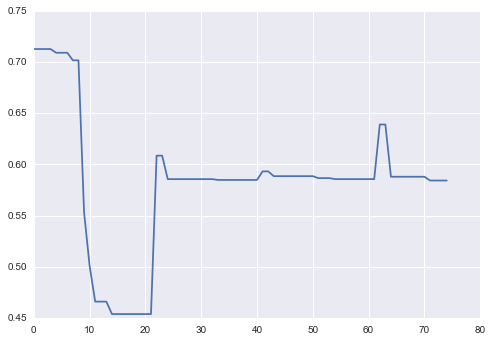

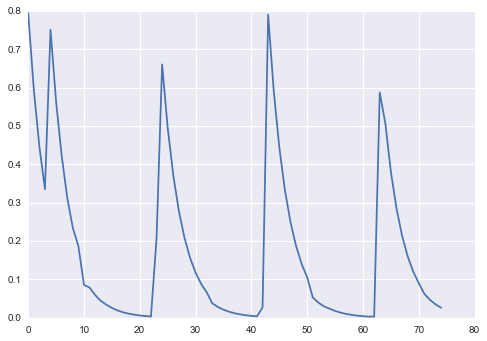

(array([ 0.9097348 ,  1.1279294 ,  1.20207417,  2.19833156]),
 0.45366492697484739,
 0.63529556799417919)

In [23]:
loglossList = np.array(loglossList)
plt.plot(loglossList)
plt.show()
plt.plot(pChangeList)
plt.show()

minIndex = np.argmin(loglossList)
paramList[minIndex], loglossList[minIndex], np.exp(-loglossList[minIndex])